# Table of Contents

>## 1. Bayesian Linear Regression
* 1.1. Probabilistic Model
* 1.2. Probabilistic Inference for the Weights
* 1.3. Probabilistic Inference for Prediction
* 1.4. Bayesian Regression Predictive for Linear Dataset
* 1.5. Bayesian Regression Predictive for Non-linear Dataset
* 1.6. Summary
* 1.7. Questions on Bayesian Regression

>## 2. Visualising Bayesian Linear Regression: Online learning
* 2.1. Recapitulating the Model
* 2.2. Inference through incremental updates
* 2.3. Visualisation
* 2.4. Summary

In [7]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# 1. Bayesian Linear Regression
* **Bayesian approach: returns uncertainty estimates**
  * Important in making decisions & performing online incremental updates to the model
  * **Step 1.** Probabilistic Model - Explicitly define our assumptions about how the data and parameters are generated
  * **Step 2.** Use the rules of probability to manipulate the probabilistic model to perform the inferences we wish to make

## 1.1. Probabilistic Model
* Probabilistic Model: a recipe (or program) for sampling datasets together with their underlying parameters
* This recipe should encode the knowledge about what we believe a typical dataset might look like before observing data
* Assumption: the observation noise $\sigma_y^2$ and prior variance on the weights $\sigma_{\mathbf{w}}^2$ are known


>1. sample the weights $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$ for $m=1...M$ 

>2. define the regression function $f_{\mathbf{w}}^{(m)}(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}^{(m)}$

>3. sample $N$ input locations $\mathbf{x}^{(m)}_n \sim p(\mathbf{x})$ for $n=1...N$

>4. sample $N$ output locations $y_n |\mathbf{w}^{(m)},\mathbf{x}^{(m)}_n,\sigma_{y}^2  \sim \mathcal{N}(f^{(m)}_{\mathbf{w}}(\mathbf{x}^{(m)}_n),\sigma_{y}^2)$ for $n=1...N$

* 4 datasets produced from this model (linear basis fn. and scalar inputs)

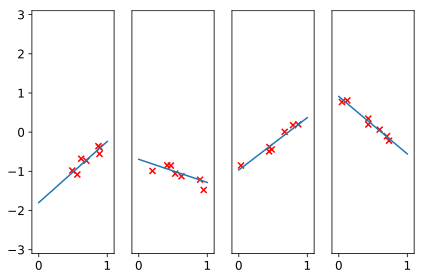

In [8]:
D = 1 # order of polynomial
M = 4 # number of samples of model
N = 7 # number of data points per model

var_w = 1 # a priori variance of weights
var_y = 0.01 # observation noise variance

# input locations
xs = np.linspace(0, 1, 100) # 100 points equispaced between 0 and 1

# polynomial basis functions
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) 


# Gaussian basis functions
# var_phi = 0.05;
# phi_pred = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in xs]) 
# phi_samp = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in x_samp])

for m in range(1, M+1):
    
    # input locations
    x_samp = np.random.uniform(0, 1, N) 

    # polynomial basis functions
    phi_samp = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp]) 


    
    # sample weights
    w = np.random.normal(0, np.power(var_w, 0.5), D+1)

    # plot function at input locations
    fs = phi_pred.dot(w) # output of the model at the points above
    
    y_samp = phi_samp.dot(w) + np.random.normal(0, np.power(var_y, 0.5), N)
    
    plt.subplot(1,M,m)
    plt.plot(xs, fs) # plot predictions
    plt.scatter(x_samp, y_samp, marker = 'x', color = 'red') # plot predictions
   
    plt.xlim([-0.1, 1.1])
    plt.ylim([-3.1, 3.1])
    if m  is not 1:
        remove_axes('y')
    
plt.tight_layout()
plt.show()

toggle_code()

#### The Probabilistic Model:
* It is a joint distribution over all of the random variables

>\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2)
\end{align}

* **All aspects of this model can be critiqued**:

>* **The assumption of independent Gaussian observation noise**:
>  * Appropriate if there are many independent noise sources & the central limit theorem holds $\Rightarrow$ Analytic inference
>  * Inappropriate if the output noise is correlated OR if there are outliers (see [Q1b](regression_linear.ipynb) and [Q2](regression_regularisation.ipynb))
>* **Zero mean Gaussian prior over the weights**:
>  * Encodes the fact that we expect the weight values to take values within a few stdev $\sigma_{\mathbf{w}}$
>  * Gaussian distribution leads to tractable inference schemes
>  * Other distributions might be appropriate
>    * E.g. Only a small no. of the features affect the output $\Rightarrow$ Sparse distributions (e.g. [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) and [Student's t](https://en.wikipedia.org/wiki/Student%27s_t-distribution)) can be more appropriate
>    * Sparse distribution: more probability mass at zero than in the tails
>* **Distribution over the input locations**:
>  * We will see that the distribution over the inputs does not affect the inference for the weights

## 1.2 Probabilistic Inference for the Weights
* **Step 1. The posterior distribution of the weights, $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$**

>\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)  \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)
\end{align}
>
>* $p(\mathbf{w}| \sigma_{\mathbf{w}}^2)$ - Prior, what we knew about the parameters before seeing data
>* $p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)$ - Likelihood, what the data tells us about the parameters

<details>
<summary>Detailed derivation for the posterior over the weights</summary>
        
Starting from the posterior distribution, $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$. we first apply the product rule,

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = 
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 }
 p(\mathbf{w},\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2).
\end{align}

Now substituing in the joint distribution specified by the probabilistic model yields

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) & =
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{X}) p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) 
  = 
  \frac{1}{
 p(\mathbf{y} | \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) \\ 
  & \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2).
\end{align}

In the last line we have dropped the term that does not depend on the weights: this is a normalising constant that we can recompute later by ensuring the distribution integrates to one. 
<div>

</div>
</details>

* **Step 2. Substitute the distributional forms for the prior and the likelihood**
  * The prior: Gaussian over the weights
  * The likelihood: also Gaussian when viewed as a function of the weights

>$$\begin{align}
p(\mathbf{w}| \sigma_{\mathbf{w}}^2) &= \frac{1}{(2\pi \sigma_{\mathbf{w}}^2)^{D/2}}\text{exp}\big(-\frac{1}{2\sigma_w^2}\mathbf{w}^\top \mathbf{w}\big)\\
p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) &= \frac{1}{(2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})\big)
\end{align}$$

* **Step 3. Product of 2 Gaussian yields another Gaussian**

>\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }).
\end{align}
>
>where 
>
>\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } & = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1} \;\;\; \text{and} \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } =  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}

<details>
<summary>Detailed derivation for the posterior mean and covariance</summary>
 
<div>
In order to find the posterior mean and covariance, we i) multiply together the prior and likelihood and expand the result in terms of an exponentiated quadratic in $\mathbf{w}$,  and then ii) compare coefficients to identify the posterior mean and covariance.
     
Step (i): Multiplying prior and likelihood 

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &\propto \text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) -\frac{1}{2 \sigma_{\mathbf{w}}^2}\mathbf{w}^\top  \mathbf{w}  \big)\\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)\mathbf{w} + \frac{1}{\sigma_y^2} \mathbf{w}^\top \boldsymbol{\Phi}^\top \mathbf{y} \right) 
\end{align}


Step (ii): comparing coefficients to a Gaussian


\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &= \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }), \\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }\mathbf{w} + \mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \right).
\end{align}

Hence the posterior covariance and mean are given by:

\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } & = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1}, \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } &=  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}

</div>
</details>

* **NOTE 1. The mean of the posterior distribution over the weights = MAP setting**

>$$\;$$
>$$
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }  = (\sigma^{-2}\boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \lambda \mathbf{I})\boldsymbol{\Phi}^\top \mathbf{y}
$$
>$$\;$$
>
>* $\lambda = \sigma^2_\mathbf{w} / \sigma^2_y $
>* This recovers the solution from regularised least squares fitting 
>* (finding the MAP setting of the weights given the data)
>
>$$\;$$
>\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2).
\end{align}
>$$\;$$

>* **Reason:** The posterior is Gaussian and the mode under a Gaussian is the mean

>$$\;$$
>\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } = \mathbb{E}_{p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}(\mathbf{w}).
\end{align}
>$$\;$$

* **NOTE 2. The prior & posterior dist. belong to the same family (i.e. Gaussian)**

>* Such prior is called a **conjugate prior**
>* Conjugate prior leads to tractable and convenient analytic posterior distributions

## 1.3. Probabilistic Inference for Prediction
* MAP & MLE: use a point estimate for the weights, $\hat{\mathbf{w}}$
* They simply compute $p(y^* | \mathbf{x}^*, \hat{\mathbf{w}},\sigma_y^2,\sigma_{\mathbf{w}}^2)$ - equivalent to assuming that the weights are known
* The full solution must be $p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$

>$$
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \int p(y^* | \mathbf{x}^*, \mathbf{w},\sigma_y^2) p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) d\mathbf{w}.
$$
>
>1. Sum over every possible weight setting,
>2. Compute the associated prediction $p(y^* | \mathbf{x}^*, \mathbf{w})$,
>3. Weight this by the posterior probability $p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$,
>4. Average these predictions

<details>
<summary>Detailed derivation for the predictive distribution</summary>
 
<div>
First we apply the sum rule to introduce the weight back into the expression. The sum rule states  $p(A|C) = \int p(A,B|C) \text{d}B$ and we use $A = y^* $, $B = \mathbf{w}$ and $C = \{x^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2\}$ so

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p(y^*,\mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Second we apply the product rule. The product rule states $p(A,B|C) = p(B|C)p(A|B,C)$ and we use the same variable associations as above to give

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Third, we use the structure of the probabilistic model to simplify the above expression (more precisely the conditional independencies implied by the model). By themselves, the test inputs $\mathbf{x}^*$ provide no information about the weights $\mathbf{w}$ so $p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p( \mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$. Moreover, if the weights $\mathbf{w}$ are known then the training data provide no additional useful information for prediction so $p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)$. 

Together these simplifications yield the expression for the predictive,

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w}.
\end{align}

</div>
</details>

* **Simple Solution w/o Integration**
>1. The posterior $p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$: Gaussian
>2. The test outputs: linear transformation of the weights + Gaussian noise
>3. Use the fact that Gaussians are closed under **linear transformation** and **addition of Gaussian noise**
>4. As a result, the predictive distribution will also be Gaussian
>$$\;$$
>\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \mathcal{N}(y^* ; \mu_{y^*|\mathbf{y},\mathbf{X}},\sigma^2_{y^*| \mathbf{y},\mathbf{X}}).
\end{align}
>$$\;$$
>\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} &= \boldsymbol{\phi}_{\ast}^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} &= \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2.
\end{align}

<details>
<summary>Detailed derivation for the mean and variance of the predictive distribution</summary>
 
<div>
In the following we lighten the notation by using the shorthand $\mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^*|\mathbf{x}^*,\mathbf{w},\sigma_y^2)}[\cdot] = \mathbb{E}[\cdot]$. Therefore
    
\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} =  \mathbb{E}[y^*] &= \mathbb{E}[\boldsymbol{\phi}_*^\top \mathbf{w} + \epsilon] = \boldsymbol{\phi}_*^\top\mathbb{E}[\mathbf{w}] = \boldsymbol{\phi}_*^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
~\\
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} = \mathbb{E}[(y^* - \mu_{y^*|\mathbf{y},\mathbf{X}})^2] &= \mathbb{E}[(\boldsymbol{\phi}_*^\top \mathbf{w} - \boldsymbol{\phi}_*^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}} + \epsilon)^2] = \mathbb{E}[(\boldsymbol{\phi}_*^\top (\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}}) + \epsilon)^2] \\
~\\
&= \boldsymbol{\phi}_*^\top \mathbb{E}[(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})^\top] \boldsymbol{\phi}_*  + \sigma_y^2\\
~\\
&= \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2
\end{align}

</div>
</details>

## 1.4. Bayesian Regression Predictive for Linear Dataset
* Solid black line: $\mu_{y^*|\mathbf{y},\mathbf{X}}$
* Grey area: $\pm \sigma_{y^*| \mathbf{y},\mathbf{X}}$
* Uncertainty grows away from the data 
* $\Rightarrow$ Reasonable since the gradient of a straight line would have a larger effect as it moves away from the data

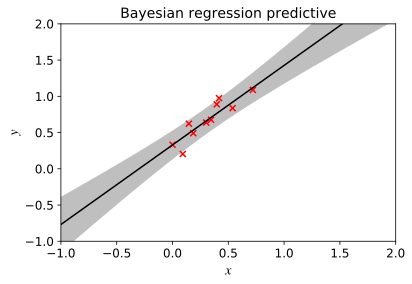

In [9]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays

var_w = 1
var_y = 0.03

phi = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_lin]) # X instantiated more elegantly here

pre_w = 1/var_w * np.eye(2) # prior covariance matrix to include in MAP solution

S = np.linalg.inv((phi.T).dot(phi) / var_y + pre_w) # posterior distribution covariance matrix
mu = S.dot(phi.T).dot(y_lin)/var_y # MAP weights to use in mean(y*)


x_pred = np.linspace(-5, 5, 100)
X_pred = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_pred])

mu_pred = X_pred.dot(mu) # calculate mean(y*)
stdev_pred = (np.sum(X_pred.dot(S) * X_pred, axis = 1) + var_y) ** 0.5 # calculate Var(y*)^0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred, facecolor = 'grey', alpha = 0.5) # plot confidence intervals = +/- Var(y*)^0.5
plt.scatter(x_lin, y_lin, marker = 'x', color = 'red') # plot data
plt.plot(x_pred, mu_pred, color = 'black') # plot mean(y*)
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.show()

toggle_code()

## 1.5. Bayesian Regression Predictive for Non-linear Dataset

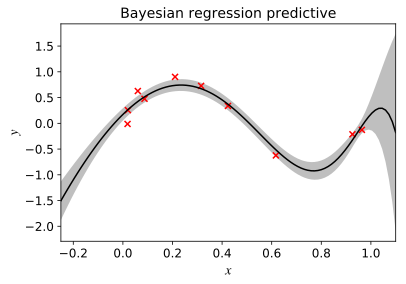

In [10]:
# exactly the same process with the linear case, except phi is different

x_nonlin = np.load('reg_nonlin_x.npy') 
y_nonlin = np.load('reg_nonlin_y.npy') # loading the non-linear dataset

var_w = 10
var_y = 0.01
D = 11;

phi = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_nonlin])
pre_w = 1/var_w * np.eye(D+1) # prior covariance matrix to include in MAP solution

S = np.linalg.inv((phi.T).dot(phi) / var_y + pre_w) # posterior distribution covariance matrix
mu = S.dot(phi.T).dot(y_nonlin)/var_y # MAP weights to use in mean(y*)

x_pred = np.linspace(-0.25, 1.1, 100)
phi_pred = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_pred])

mu_pred = phi_pred.dot(mu)
stdev_pred = (np.sum(phi_pred.dot(S) * phi_pred, axis = 1) + var_y) ** 0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred,
                 facecolor = 'grey', alpha = 0.5)
plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red')
plt.plot(x_pred, mu_pred, color = 'black')
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-0.25, 1.1])
plt.show()

toggle_code()

## 1.6. Summary

Why finding the $\mathbf{w}$ using MAP with a gaussian likelihood and prior is equivalent to doing least-squares with $\mathbf{L2}$ regularization


How to take a bayesian inference approach to regression problems, including how to calculate $\mathbb{E}$(y) and Var(y) for your fitted model.

## 1.7. Questions on Bayesian Regression

* **Q1a. Consider the the Bayesian regression described above. Show that, in addition to the number of datapoints $N$, the posterior distribution only requires the following statistics to be computed from the training data,**

\begin{align}
\mu^{(N)}_{d} &= \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) y_n, \;\; \text{and} \;\;
\Sigma^{(N)}_{d,d'} = \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) \phi_{d'}(\mathbf{x}_n). 
\end{align}


<details>
<summary>Answer</summary>
<div>
Computing the posterior distribution requires the following two statistics $\boldsymbol{\Phi}^\top \mathbf{y}$   and $\boldsymbol{\Phi}^\top \boldsymbol{\Phi}$. Dividing these two statistics by $N$ and expanding them using index notation yields the expressions above.
    
The fact that the inference depends only on the empirical average of a small number of simple functions of the data is an example of **suffiecnt statistics**. Sufficient statistics arise when employing probabilistic models with elements that employ [exponential family distributions](https://en.wikipedia.org/wiki/Exponential_family) like the Gaussian.
</div>
</details>

* **Q1b. Consider applying Bayesian regression on streaming data where one datapoint $\{ \mathbf{x}_n, y_n\}$ arrives at a time and the posterior is continually updated as data come in.**

Derive an update where the statistics ($\mu^{(N)}_{d}$ and $\Sigma^{(N)}_d$) are recomputed using the old values of the statitics ($\mu^{(N-1)}_{d}$ and $\Sigma^{(N-1)}_d$) and the current datapoint ($\{ \mathbf{x}_n, y_n\}$). 

What advantage does this have for very long data streams $N \rightarrow \infty$?


<details>
<summary>Answer</summary> 
    
<div>
    Consider the update for $\mu^{(N)}_{d}$. Splitting out the contribution from the $N$th datapoint, we have  

\begin{align}
\mu^{(N)}_{d} &= \frac{1}{N}\sum_{n=1}^N \phi_d(\mathbf{x}_n) y_n = \frac{1}{N} \left(\phi_d(\mathbf{x}_N) y_N + \sum_{n=1}^{N-1} \phi_d(\mathbf{x}_n) y_n \right )\\ 
    &  = \frac{1}{N} \left(\phi_d(\mathbf{x}_N) y_N + \frac{N-1}{N-1}\sum_{n=1}^{N-1} \phi_d(\mathbf{x}_n) y_n \right)\\
    &  = \frac{1}{N} \phi_d(\mathbf{x}_N) y_N + \frac{N-1}{N} \mu^{(N-1)}_d
\end{align}

This is the idea of a 'running average'. Similarly for $\Sigma^{(N)}_{d,d'}$ 

\begin{align}
\Sigma^{(N)}_{d,d'} &= \frac{1}{N} \phi_d(\mathbf{x}_N) \phi_{d'}(\mathbf{x}_N) + \frac{N-1}{N} \Sigma^{(N-1)}_{d,d'}. 
\end{align}

These updates do not require the entire dataset to be retained. They just require the old statistics and the current datapoint, which can be much more efficient in terms of memory. This idea relates to [online inference](regression_bayesian-online-visualisations.ipynb).

</div>
</details>

# 2. Visualising Bayesian Linear Regression: Online learning

* **Online** or **Incremental** updates
  * Inference is updated using the previous posterior distribution and the current data
  * It does not require the old data
  * Faster & more memory efficient than **batch** updates which have to retain the whole dataset
  * Widely used in high-frequency trading or in an autonomous robot that is continuously localising itself in an environment

## 2.1. Recapitulating the Model

>\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2) \;\; \text{where} \;\; f_{\mathbf{w}}.(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}.
\end{align}
>
>* We will suppress the parameters $\sigma_{\mathbf{w}}^2$ and $\sigma_y^2$ to lighten the notation.

## 2.2. Inference through incremental updates

* After **ONE** datapoint
>$$
p(\mathbf{w}| y_1, \mathbf{x}_1) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w})
$$

* After **TWO** datapoints
>$$
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w}) p(y_2| \mathbf{x}_2, \mathbf{w})
$$

* Rewrite this by treating **the previous posterior** as the new **prior**
>$$
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}| y_1, \mathbf{x}_1) p(y_2| \mathbf{x}_2, \mathbf{w}).
$$

* Extension to $N$ datapoints
>$$
p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) \propto p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^{N-1}_{n = 1}) p(y_N| \mathbf{x}_N, \mathbf{w}).
$$

* At any point during the process the updated posterior can be used to make predictions in the usual way
>$$
p(y^* | \mathbf{x}^*,  \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1} ) = \int p(y^* | \mathbf{x}^*, \mathbf{w}) p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) d\mathbf{w}.
$$

## 2.3. Visualisation
* Bayesian straight line fitting, $y=w_0 + w_1 x_1 + \epsilon$
* Visualise **Prior**, **Likelihood**, and **Posterior**
* Also, draw $3$ weight samples from the posterior and plot the corresponding lines

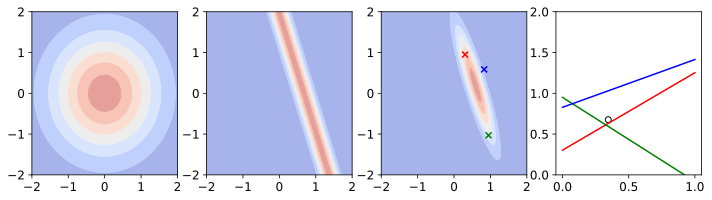

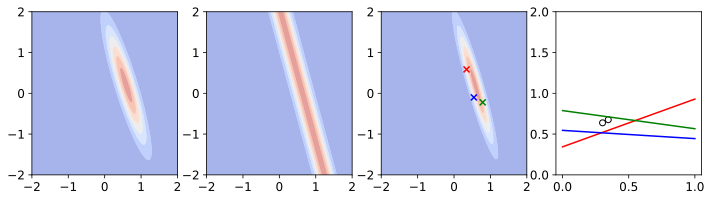

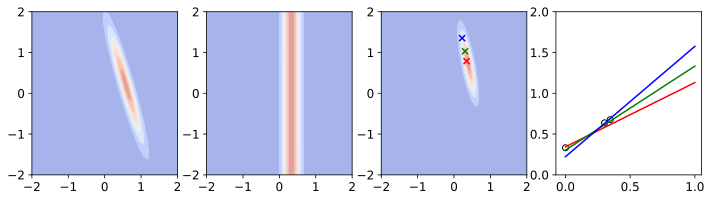

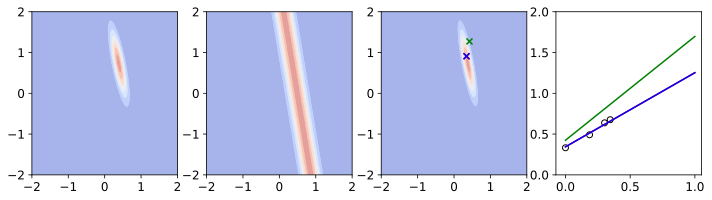

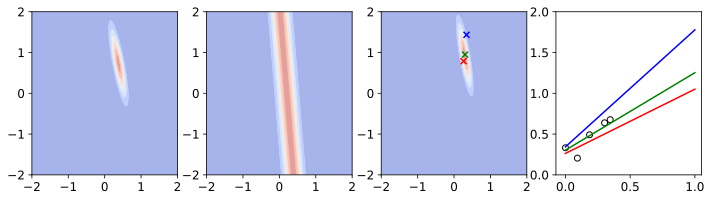

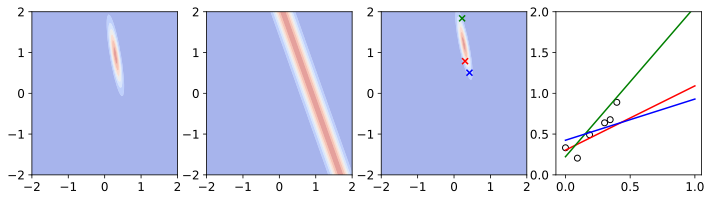

In [11]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays


w1_range, w2_range = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100) # specify the range of weights to be visualised
w1, w2 = np.meshgrid(w1_range, w2_range) # returns two 2d arrays with the values of w1_range and w2_range (see docs!)
grid = np.stack([w1, w2], axis = 2) # stack the two grids together to do aritmetic elegantly later

var_w = 1
var_y = 0.03
no_points = 5 # do the algorithm for no_points sequential observations

colours = ['red', 'green', 'blue']
x_ = np.linspace(0, 1, 100)

for n in range(no_points + 1):

    X = np.array([[x_lin[n] ** d for d in range(0, 2)]]) # X contains a single point (x[n]) for online learning
    
    if n == 0:
        log_prior = -1/2*np.sum(grid.dot(np.eye(2) ) * grid, axis = 2)/ var_w # quadratic form of prior (goes in the exponent)
        
    log_lik = -1 / 2 *np.sum((y_lin[n] - grid.dot(X.T)) ** 2, axis = 2)/var_y # quadratic form of likelihood of (x[n], y[n]) point
    
    log_post = log_prior + log_lik # posterior is prior*lik by Bayes' rule

    plt.figure(figsize = (12, 3)) # add new figure to plot this step
    for i, values in enumerate([np.exp(log_prior-np.amax(log_prior)), np.exp(log_lik-np.amax(log_lik)), np.exp(log_post-np.amax(log_post))]):
        plt.subplot(1, 4, i + 1)
        plt.contourf(w1_range, w2_range, values, cmap = 'coolwarm', alpha = 0.5) # plot prior after n points
    
    w1s, w2s = [[],[]] # initialising 2 empty arrays to store old weights
    
    for i in range(3):
        post = np.exp(log_post)
        w1, w2 = sample_weights_from(w2_range, w1_range, post)
        w1s.append(w1)
        w2s.append(w2)
        plt.scatter(w1, w2, marker = 'x', color = colours[i])
        
    plt.subplot(144)
    for i in range(3):
        plt.plot(x_, w1s[i] + w2s[i] * x_, color = colours[i])
        #remove_axes()
    
    plt.scatter(x_lin[:n + 1], y_lin[:n + 1], marker = 'o', facecolor = 'None', edgecolor = 'black')
    plt.ylim([0, 2])
    
    log_prior = log_post.copy() # set prior of the next step to be the posterior of the current step

plt.show()

toggle_code()

## 2.4. Summary

Bayesian updating naturally supports online or incremental updates: the old posterior is multiplied by the new likelihood and renormalised to get the new posterior

The posterior typically evolves from a diffuse initial prior, through to a concentrated posterior as more data arrive and the likelihood functions rule out many parameter settings  